# Restaurant Data Analysis — MySQL to Python Visualization

### Connect MySQL to Python

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import mysql.connector

# Connect to database
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1234",
    database="restaurant_db"
)

cur = db.cursor()

### Top 10 Most Ordered Items. 

In [35]:
query = """
SELECT 
    m.item_name, COUNT(o.order_details_id) AS total_orders
FROM
    order_details o
        JOIN
    menu_items m ON o.item_id = m.menu_item_id
GROUP BY m.item_name
ORDER BY total_orders DESC
LIMIT 10;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['item_name','total_orders'])
df_sorted = df.sort_values(by='total_orders')
fig = px.bar(df_sorted, x='total_orders', y='item_name', text = 'total_orders',title= 'Top 10 Most Ordered Items')


fig.show('iframe')

### Category with highest number of Menu Items. 

In [34]:
query = """
SELECT 
    category, COUNT(menu_item_id) AS total_menu_items
FROM
    menu_items
GROUP BY category
ORDER BY total_menu_items DESC;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['category','total_menu_items'])
df_sorted = df.sort_values('total_menu_items', ascending= False)

fig = px.bar(df_sorted, x='category', y='total_menu_items', text = 'total_menu_items', orientation= 'v',
             title= 'Category with highest number of Menu Items')
fig.show('iframe')

### Average Price of Menu Items per Category. 

In [33]:
query = """
SELECT 
    category, ROUND(AVG(price), 2) AS avg_price
FROM
    menu_items
GROUP BY category;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['category','avg_price'])
color = ['#2AAA8A','#2E8B57','#4F7942','#008080']
fig = px.pie(df, names = 'category', values = 'avg_price', hole = 0.5 ,color_discrete_sequence= color,
             title = 'Average Price of Menu Items per Category')

fig.update_traces(textinfo='label+ value')

fig.show('iframe')

### Most Orders Day-Wise. 

In [40]:
query = """
SELECT 
    DAYNAME(order_date) AS day_name,
    COUNT(distinct order_id) AS total_orders
FROM
    order_details
GROUP BY DAYNAME(order_date);
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['day_name','total_orders'])

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

df['day_name'] = pd.Categorical(df['day_name'], categories=order, ordered=True)
df = df.sort_values('day_name')

fig = px.bar(df, x='day_name', y="total_orders", text = 'total_orders',title= 'Most Orders Day-Wise')

fig.show('iframe')

### Distribution of Orders by Time of Day. 

In [36]:
query = """
SELECT 
    CASE
        WHEN HOUR(order_time) < 12 THEN 'morning'
        WHEN HOUR(order_time) < 17 THEN 'afternoon'
        WHEN HOUR(order_time) < 20 THEN 'evening'
        ELSE 'night'
    END AS time_of_day,
    count(*) as total_orders
FROM
    order_details
    group by time_of_day;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['time_of_day','total_order'])

colors = ['#d0e1f9', '#74a9cf', '#2b5788', '#0d1b2a']
fig = px.pie(df, names = 'time_of_day', values = 'total_order', color_discrete_sequence= colors, title = 'Distribution of Orders by Time of Day')

max_index = df['total_order'].idxmax()  
pull_values = [0.2 if i == max_index else 0 for i in range(len(df))]

fig.data[0].pull = pull_values
fig.update_traces(textinfo='label+value')
fig.show('iframe')

### Total Revenue generated per Category

In [41]:
query = """
SELECT 
    m.category, SUM(m.price) AS revenue
FROM
    menu_items m
        JOIN
    order_details o ON m.menu_item_id = o.item_id
GROUP BY m.category;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['category','revenue'])
fig = px.bar(df, x='revenue', y='category', text = 'revenue',title= 'Total Revenue generated per Category', orientation= 'h')
fig.show('iframe')

### Top 5 Menu Items contribute the most to Total Revenue. 

In [42]:
query = """
SELECT 
    m.item_name,
    sum(price) as total_revenue
FROM
    menu_items m
        JOIN
    order_details o ON m.menu_item_id = o.item_id
GROUP BY m.item_name
ORDER BY total_revenue DESC
LIMIT 5;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['item_name','revenue'])
fig = px.pie(df, names = 'item_name', values = 'revenue' ,hole = 0.8,title = 'Top 5 Menu Items contribute the most to Total Revenue.')

max_index = df['revenue'].idxmax()  
pull_values = [0.2 if i == max_index else 0 for i in range(len(df))]

fig.data[0].pull = pull_values
fig.update_traces(textinfo='label+value')
fig.show('iframe')

### Daily Sales trends for the last 30 days. 

In [43]:
query = """
SELECT 
    order_date, COUNT(order_details_id) AS qty_sold
FROM
    order_details
WHERE order_date >= (
SELECT 
        MAX(order_date) - INTERVAL 30 DAY
FROM
        order_details)
GROUP BY order_date;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['order_date','qty_sold'])
fig = px.bar(df, x='order_date', y="qty_sold", text = 'qty_sold',title= 'Daily Sales trends for the last 30 days')
fig.show('iframe')

### Days of the Week with the Highest Average Revenue.

In [44]:
query = """
SELECT 
    DAYNAME(order_date) AS days,
    ROUND(AVG(daily_revenue),2) AS avg_revenue
FROM
(SELECT 
    o.order_date, SUM(m.price) AS daily_revenue
FROM
    order_details o
        JOIN
    menu_items m ON o.item_id = m.menu_item_id
GROUP BY o.order_date
) AS daily_revenue
GROUP BY days;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['days','avg_revenue'])
fig = px.line(df, x="days", y="avg_revenue", text = 'avg_revenue' ,title = 'Days of the Week with the Highest Average Revenue')

fig.show(renderer="iframe")


### Top-Selling Item for each Category.

In [45]:
query = """
WITH data AS (
SELECT 
    m.category, m.item_name, COUNT(o.order_details_id) AS sales,
    ROW_NUMBER() OVER (PARTITION BY m.category ORDER BY COUNT(o.order_details_id) DESC) AS ranks
FROM
    menu_items m
        JOIN
    order_details o ON m.menu_item_id = o.item_id
GROUP BY m.category , m.item_name)

SELECT 
    *
FROM
    data d
WHERE
    ranks = 1;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['category','item_name','sales','ranks'])
df_sorted = df.sort_values(by='sales')


fig = px.bar(df_sorted, x='sales', y='item_name', orientation='h', color = 'category', text = 'sales')
fig.update_layout(title='Top-Selling Item for each Category.')
fig.show(renderer="iframe")

### Sales Contribution of Top 3 Menu Items.

In [46]:
query = """
SELECT 
    m.item_name,
    COUNT(o.order_details_id) AS total_sales,
    ROUND((COUNT(o.order_details_id) / (SELECT 
                    COUNT(order_details_id)
                FROM
                    order_details)) * 100,
            2) AS pct_of_total_sales
FROM
    order_details o
        JOIN
    menu_items m ON o.item_id = m.menu_item_id
GROUP BY m.item_name
ORDER BY total_sales DESC
LIMIT 3;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['item_name','total_sales','pct_of_total_sales'])

fig = px.pie(df, names = 'item_name', values = 'pct_of_total_sales' ,title = 'Sales Contribution of Top 3 Menu Items')

fig.update_traces(textinfo='label+ value')

fig.show('iframe')

###  Top 5 Least Ordered Items. 

In [47]:
query = """
SELECT 
    m.item_name, COUNT(o.order_details_id) AS total_orders
FROM
    order_details o
        JOIN
    menu_items m ON o.item_id = m.menu_item_id
GROUP BY m.item_name
ORDER BY total_orders
limit 5;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['item_name','total_orders'])
fig = px.bar(df, x= 'item_name', y= 'total_orders', text = 'total_orders', title = 'Top 5 Least Ordered Items')
fig.show('iframe')

### Top 3 Revenue-Generating Items per Category.

In [48]:
query = """
WITH revenue_per_item AS (
SELECT 
    m.category,
    m.item_name,
    SUM(m.price) AS revenue,
    DENSE_RANK() OVER (PARTITION BY category ORDER BY SUM(m.price) DESC) AS ranks
FROM
    menu_items m
        JOIN
    order_details o ON m.menu_item_id = o.item_id
GROUP BY m.category , m.item_name)
SELECT 
    *
FROM
    revenue_per_item
WHERE
    ranks <= 3;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['category','menu_items','revenue','ranks'])
fig = px.bar(df, x= 'menu_items', y= 'revenue', color ='category', text = 'revenue', title = 'Top 3 Revenue-Generating Items per Category')
fig.update_xaxes(tickangle=270)
fig.show('iframe')

### Peak Revenue Hours. 

In [49]:
query = """
SELECT 
    Hour(o.order_time) AS hours,
    COUNT(o.order_details_id) AS sales,
    SUM(m.price ) AS revenue
FROM
    order_details o
        JOIN
    menu_items m ON o.item_id = m.menu_item_id
GROUP BY hours
ORDER BY sales DESC;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['hours','sales','revenue'])
fig = px.scatter(df, x="hours", y="revenue", size="sales", title = 'Peak Revenue Hours')
fig.show('iframe')

### Week-over-Week Revenue Growth

In [50]:
query = """
WITH weekly_revenue AS( 
SELECT 
    WEEK(order_date) AS week,
    SUM(m.price) AS cur_week_revenue
FROM
    order_details o
        JOIN
    menu_items m ON o.item_id = m.menu_item_id
GROUP BY week)

SELECT 
    week,
    cur_week_revenue,
    LAG(cur_week_revenue) OVER (ORDER BY week) AS prev_week_revenue,
    ROUND(((cur_week_revenue - LAG(cur_week_revenue) OVER (ORDER BY week)) /LAG(cur_week_revenue) OVER (ORDER BY week)) * 100,
            2) AS WoW_change
FROM
    weekly_revenue;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['week','cur_week_revenue','prev_week_revenue','WoW_change'])
fig = px.line(df, x='week', y='WoW_change', text = 'WoW_change',title = 'Week-over-Week Revenue Growth')
fig.add_hline(y=0, line_dash="dot", line_color="blue")
fig.show(renderer="iframe")

### Identifying Seasonal Items.

In [21]:
query = """
SELECT 
    m.item_name,
    COUNT(DISTINCT MONTH(o.order_date)) AS active_months
FROM
    menu_items m
        JOIN
    order_details o ON m.menu_item_id = o.item_id
GROUP BY m.item_name
HAVING active_months < 3
ORDER BY active_months;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['item_name','active_months'])
print(df)

Empty DataFrame
Columns: [item_name, active_months]
Index: []


### Revenue Contribution: High-Priced vs. Low-Priced Items

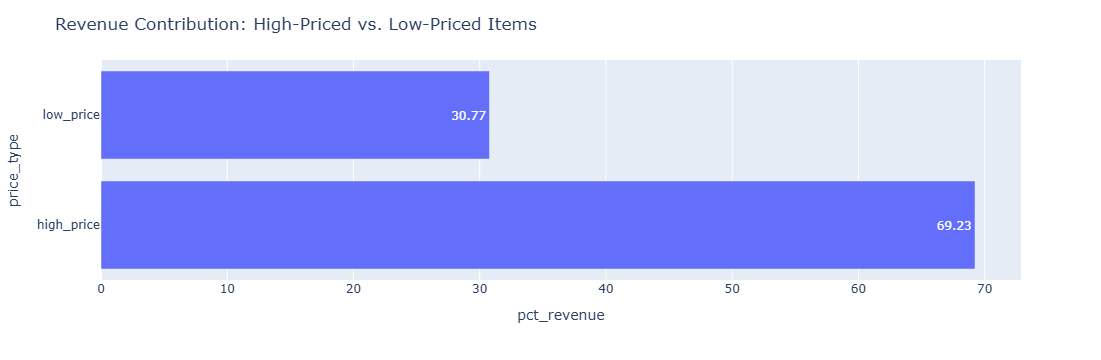

In [51]:
query = """
SELECT 
    CASE
        WHEN
            m.price > (SELECT 
                    ROUND(AVG(mi.price), 2)
                FROM
                    menu_items mi)
        THEN
            'high_price'
        ELSE 'low_price'
    END AS price_type,
    SUM(m.price) AS revenue,
    ROUND((SUM(m.price) / (SELECT 
                    SUM(price)
                FROM
                    menu_items mi
                        JOIN
                    order_details od ON mi.menu_item_id = od.item_id)) * 100,
            2) AS pct_revenue
FROM
    menu_items m
        JOIN
    order_details o ON m.menu_item_id = o.item_id
GROUP BY price_type;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['price_type','revenue','pct_revenue'])
fig = px.bar(df, x='pct_revenue', y='price_type', orientation='h', hover_data= 'revenue', text = 'pct_revenue')
fig.update_layout(title='Revenue Contribution: High-Priced vs. Low-Priced Items')
fig.show()

### Category with the Highest Variability in Daily Sales

In [23]:
query = """
SELECT 
    category, ROUND(STDDEV(daily_sales),2) AS variability
FROM
    (SELECT 
        m.category,
            o.order_date,
            COUNT(o.order_details_id) AS daily_sales
    FROM
        menu_items m
    JOIN order_details o ON m.menu_item_id = o.item_id
    GROUP BY m.category , o.order_date) AS d
GROUP BY category
ORDER BY variability DESC;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['category','variability'])
fig = px.pie(df, values = 'variability', names = 'category', hole= 0.8, title = 'Category with the Highest Variability in Daily Sales')
fig.update_traces(textinfo='label+ value')
fig.show()

### Avg. Number of Items per Order. 

In [24]:
query = """
SELECT 
    ROUND(AVG(item_per_order), 2) AS avg_busket_size
FROM
    (SELECT DISTINCT
        o.order_id, COUNT(o.item_id) AS item_per_order
    FROM
        order_details o
    JOIN menu_items m ON o.item_id = m.menu_item_id
    GROUP BY o.order_id) AS data;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['avg_busket_size'])
print(df)

  avg_busket_size
0            2.26


### Peak Ordering Periods Across the Week.

In [53]:
query = """
SELECT 
    DAYNAME(o.order_date) AS days,
    CASE
        WHEN HOUR(order_time) < 12 THEN 'morning'
        WHEN HOUR(order_time) < 17 THEN 'afternoon'
        WHEN HOUR(order_time) < 20 THEN 'evening'
        ELSE 'night'
    END AS time_slot,
    COUNT(o.order_details_id) AS total_orders
FROM
    order_details o
GROUP BY days , time_slot;
"""

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data, columns = ['days','time_slot','total_orders'])
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
time_order = ['night', 'evening', 'afternoon','morning']
heatmap_data = df.pivot(index='time_slot', columns='days', values='total_orders')
heatmap_data = heatmap_data.reindex(index=time_order)
heatmap_data = heatmap_data.reindex(columns = day_order)

# Create heatmap
fig = px.imshow(heatmap_data, text_auto=True, color_continuous_scale='Blues', title = 'Peak Ordering Periods Across the Week')

fig.show('iframe')